![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Exercise 5 - RNN </center>
### <center> Many to One RNN </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/Exercises/Ex5/Exercise05_RNN.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [2]:
if 'google.colab' in str(get_ipython()):
    !npx degit FixelAlgorithmsTeam/FixelCourses/DeepLearningMethods/Exercises/Ex5/DeepLearningFramework ./DeepLearningFramework

In [3]:
import numpy             as np
import matplotlib.pyplot as plt

import torch
import torch.nn    as nn
import torch.optim as optim
import torchtext

from torchtext.vocab import Vocab

### Exercise:
Get above 80% accuracy on the `Names` dataset.

### Load the data:

In [4]:
mData   = np.load('NamesData.npy')
lNames  = mData[:,0]
lLabels = mData[:,1]
N       = mData.shape[0]

vIdx    = np.random.randint(0, N, (5,))
print(f'Some names : {[f"{lNames [idx]:13}" for idx in vIdx]}')
print(f'Some labels: {[f"{lLabels[idx]:13}" for idx in vIdx]}')

Some names : ['Deeb         ', 'Jerebtsov    ', 'Amato        ', 'Dubhain      ', 'Amari        ']
Some labels: ['Arabic       ', 'Russian      ', 'Italian      ', 'Irish        ', 'Arabic       ']


#### Build the vocabulary:

In [5]:
from string          import ascii_letters
from torchtext.vocab import build_vocab_from_iterator

oVocab   = build_vocab_from_iterator([c for c in ascii_letters])
nLetters = len(oVocab)

print (f'Number of letter: {len(oVocab)}')
oVocab(['A', 'B', 'C', 'a', 'b', 'z'])

Number of letter: 52


[0, 1, 2, 26, 27, 51]

#### Label encoder:

In [6]:
from sklearn.preprocessing import LabelEncoder

oLabelEncoder = LabelEncoder().fit(lLabels)
nLabels       = len(oLabelEncoder.classes_)

print(f'Number of labels: {nLabels}'               )
print(f'Labels:         \n{oLabelEncoder.classes_}')

Number of labels: 18
Labels:         
['Arabic' 'Chinese' 'Czech' 'Dutch' 'English' 'French' 'German' 'Greek'
 'Irish' 'Italian' 'Japanese' 'Korean' 'Polish' 'Portuguese' 'Russian'
 'Scottish' 'Spanish' 'Vietnamese']


In [7]:
oLabelEncoder.transform(['Arabic', 'Czech'])

array([0, 2])

#### String to tensor:

In [12]:
def Name2Tensor(name):
    return torch.tensor(oVocab(list(name)))

def Tensor2Name(vName):
    return ''.join([oVocab.get_itos()[e] for e in vName])

name  = 'Jones'
vName = Name2Tensor(name)

Name2Tensor(name), Tensor2Name(vName)

(tensor([ 9, 40, 39, 30, 44]), 'Jones')

#### Dataset:
`__getitem__`:
* `vName` is the tensor version of the string `name`.
* `y` is the integer represents the class `label`.

In [11]:
class NameDataset(torch.utils.data.Dataset):
    def __init__(self, lNames, lLabels):
        self.lNames  = lNames
        self.lLabels = lLabels
        
    def __len__(self):
        return ???
    
    def __getitem__(self, idx):
        ???
        ???
        return vName, y
    
oDataset = NameDataset(lNames, lLabels)
vName, y = oDataset[20001]

Tensor2Name(vName), oLabelEncoder.inverse_transform([y])

('Nguyen', array(['Vietnamese'], dtype='<U19'))

In [12]:
from torch.utils.data import random_split

N                   = mData.shape[0]
nTrain              = 15000
nTest               = N - nTrain
oTrainSet, oTestSet = random_split(oDataset, [nTrain, nTest], generator=torch.Generator().manual_seed(42))

len(oTrainSet), len(oTestSet)

(15000, 5074)

#### Data loader:
* `vY` is a tensor (`dtype=torch.long`) of the classes.
* `mPackNames` is a packed object of the names.

In [13]:
from torch.nn.utils.rnn import pack_sequence

def NamesCollate(lBatch):
    lNames, lY = zip          (*lBatch)
    vY         = ???
    mPackNames = ???
    
    return mPackNames, vY

batchSize = 64
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=1*batchSize, collate_fn=NamesCollate)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, collate_fn=NamesCollate)

mPackNames,            vY = next(iter(oTrainDL))
mPackNames.data.shape, vY.shape

(torch.Size([439]), torch.Size([64]))

#### Model:
Use `bidirectional=True` (just for practice).

In [14]:
from torch.nn.utils.rnn import PackedSequence

H = ??? #-- Hidden dim
V = ??? #-- Vocabulary size
D = ??? #-- Embedding dim
L = ??? #-- Number of layers
C = ??? #-- Number of classes

def PackedAs(mX, mPack):
    return PackedSequence(mX, mPack.batch_sizes, mPack.sorted_indices, mPack.unsorted_indices)

class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
       
        self.oEmbeeding = ???
        self.oGRU       = ???
        self.oLinear    = ???
        
    def forward(self, mPackNames):
        #-- mPackNames.shape = (N*T,)
        
        mE     = self.oEmbeeding(???)                             #-- mE        .shape = (N*T, D)
        mPackE = PackedAs       (mE, mPackNames)                  #-- mPackE    .shape = (N*T, D)
        
        _, mH  = self.oGRU      (???)                             #-- mH        .shape = (2*L, N, H) 
        mH     = torch.cat      ([mH[-1,:,:], mH[-2,:,:]], dim=1) #-- mH        .shape = (N,   2*H)
               
        mZ     = self.oLinear   (???)                             #-- mZ        .shape = (N, C)
        
        return mZ
    
RNN()(mPackNames).shape

torch.Size([64, 18])

#### Train:

In [15]:
from torch.optim.lr_scheduler       import OneCycleLR
from DeepLearningFramework.Metric   import Accuracy
from DeepLearningFramework.Training import TrainModel

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
Loss   = nn.CrossEntropyLoss()
Metric = Accuracy           ()

In [16]:
nEpochs       = 50
nIter         = nEpochs * len(oTrainDL)

oModel        = RNN        ().to(DEVICE)
oOptim        = ???
oScheduler    = ???
lHistory      = TrainModel (oModel, oTrainDL, oTestDL, Loss, Metric, nEpochs, oOptim, oScheduler, sModelName='ManyToOne');

------------------------------------------------------------------------------------------------------------------------
Epoch 000: | Train loss:  2.339 | Val loss:  1.863 | Train Metric:  0.443 | Val Metric:  0.463 | epoch time:  2.766 | <-- Checkpoint!
Epoch 001: | Train loss:  1.798 | Val loss:  1.765 | Train Metric:  0.471 | Val Metric:  0.463 | epoch time:  2.131 |
Epoch 002: | Train loss:  1.682 | Val loss:  1.577 | Train Metric:  0.492 | Val Metric:  0.516 | epoch time:  2.058 | <-- Checkpoint!
Epoch 003: | Train loss:  1.471 | Val loss:  1.362 | Train Metric:  0.555 | Val Metric:  0.575 | epoch time:  2.039 | <-- Checkpoint!
Epoch 004: | Train loss:  1.314 | Val loss:  1.230 | Train Metric:  0.603 | Val Metric:  0.628 | epoch time:  2.034 | <-- Checkpoint!
Epoch 005: | Train loss:  1.187 | Val loss:  1.111 | Train Metric:  0.647 | Val Metric:  0.666 | epoch time:  2.042 | <-- Checkpoint!
Epoch 006: | Train loss:  1.075 | Val loss:  1.008 | Train Metric:  0.676 | Val Metric:  0.

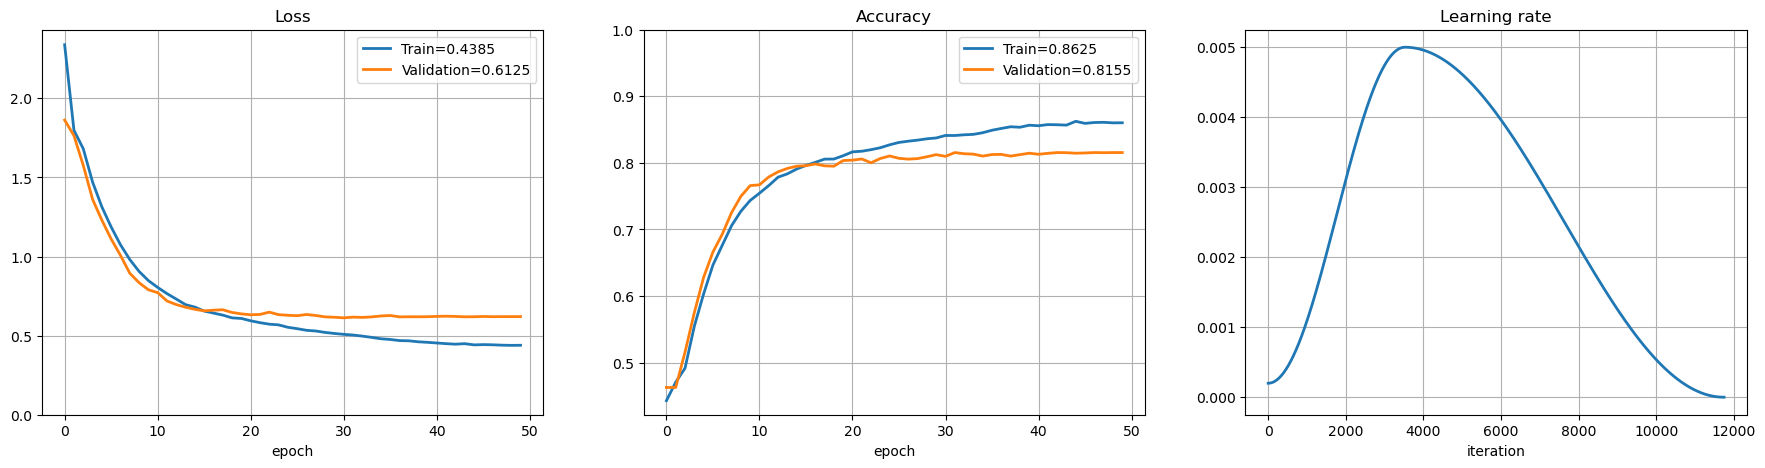

In [17]:
from DeepLearningFramework.Auxiliary import PlotHistory

PlotHistory(lHistory)
plt.show   ()